In [1]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#@title resnet.py
# Modified from
# https://github.com/pytorch/vision/blob/release/0.8.0/torchvision/models/resnet.py
import torch
from torch import Tensor
import torch.nn as nn
# from torchvision.models.utils import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional
from torch.hub import load_state_dict_from_url
__all__ = [
    'ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
    'resnext50_32x4d', 'resnext101_32x8d', 'wide_resnet50_2',
    'wide_resnet101_2'
]

model_urls = {
    'resnet18':
    'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34':
    'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50':
    'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101':
    'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152':
    'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d':
    'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d':
    'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2':
    'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2':
    'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes: int,
            out_planes: int,
            stride: int = 1,
            groups: int = 1,
            dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=dilation,
                     groups=groups,
                     bias=False,
                     dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
            self,
            inplanes: int,
            planes: int,
            stride: int = 1,
            downsample: Optional[nn.Module] = None,
            groups: int = 1,
            base_width: int = 64,
            dilation: int = 1,
            norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError(
                'BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        # self.bn1 = norm_layer(planes)
        # Rename relu to relu1
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        # self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        self.skip_add = nn.quantized.FloatFunctional()
        # Remember to use two independent ReLU for layer fusion.
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        # out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        # out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # Use FloatFunctional for addition for quantization compatibility
        # out += identity
        # out = torch.add(identity, out)
        out = self.skip_add.add(identity, out)
        out = self.relu2(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
            self,
            inplanes: int,
            planes: int,
            stride: int = 1,
            downsample: Optional[nn.Module] = None,
            groups: int = 1,
            base_width: int = 64,
            dilation: int = 1,
            norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu1 = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.skip_add = nn.quantized.FloatFunctional()
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # out += identity
        # out = torch.add(identity, out)
        out = self.skip_add.add(identity, out)
        out = self.relu2(out)

        return out


class ResNet(nn.Module):
    def __init__(
            self,
            block: Type[Union[BasicBlock, Bottleneck]],
            layers: List[int],
            num_classes: int = 1000,
            zero_init_residual: bool = False,
            groups: int = 1,
            width_per_group: int = 64,
            replace_stride_with_dilation: Optional[List[bool]] = None,
            norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(
                                 replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3,
                               self.inplanes,
                               kernel_size=7,
                               stride=2,
                               padding=3,
                               bias=False)
        # self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block,
                                       128,
                                       layers[1],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block,
                                       256,
                                       layers[2],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block,
                                       512,
                                       layers[3],
                                       stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight,
                                      0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight,
                                      0)  # type: ignore[arg-type]

    def _make_layer(self,
                    block: Type[Union[BasicBlock, Bottleneck]],
                    planes: int,
                    blocks: int,
                    stride: int = 1,
                    dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                # norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(self.inplanes, planes, stride, downsample, self.groups,
                  self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes,
                      planes,
                      groups=self.groups,
                      base_width=self.base_width,
                      dilation=self.dilation,
                      norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        # x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(arch: str, block: Type[Union[BasicBlock,
                                         Bottleneck]], layers: List[int],
            pretrained: bool, progress: bool, **kwargs: Any) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained: bool = False,
             progress: bool = True,
             **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained: bool = False,
             progress: bool = True,
             **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained: bool = False,
             progress: bool = True,
             **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained: bool = False,
              progress: bool = True,
              **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained,
                   progress, **kwargs)


def resnet152(pretrained: bool = False,
              progress: bool = True,
              **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained,
                   progress, **kwargs)


def resnext50_32x4d(pretrained: bool = False,
                    progress: bool = True,
                    **kwargs: Any) -> ResNet:
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3], pretrained,
                   progress, **kwargs)


def resnext101_32x8d(pretrained: bool = False,
                     progress: bool = True,
                     **kwargs: Any) -> ResNet:
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3], pretrained,
                   progress, **kwargs)


def wide_resnet50_2(pretrained: bool = False,
                    progress: bool = True,
                    **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3], pretrained,
                   progress, **kwargs)


def wide_resnet101_2(pretrained: bool = False,
                     progress: bool = True,
                     **kwargs: Any) -> ResNet:
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3], pretrained,
                   progress, **kwargs)

In [3]:
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import time
import copy
import numpy as np

# from resnet import resnet18
import tracemalloc


def set_random_seeds(random_seed=0):

    torch.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)


def prepare_dataloader(num_workers=8,
                       train_batch_size=128,
                       eval_batch_size=256):

    train_transform = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
    ])

    train_set = torchvision.datasets.CIFAR10(root="data",
                                             train=True,
                                             download=True,
                                             transform=train_transform)
    # We will use test set for validation and test in this project.
    # Do not use test set for validation in practice!
    test_set = torchvision.datasets.CIFAR10(root="data",
                                            train=False,
                                            download=True,
                                            transform=test_transform)

    train_sampler = torch.utils.data.RandomSampler(train_set)
    test_sampler = torch.utils.data.SequentialSampler(test_set)

    train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=train_batch_size,
                                               sampler=train_sampler,
                                               num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=eval_batch_size,
                                              sampler=test_sampler,
                                              num_workers=num_workers)

    return train_loader, test_loader


def evaluate_model(model, test_loader, device, criterion=None):

    model.eval()
    model.to(device)

    running_loss = 0
    running_corrects = 0

    for inputs, labels in test_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        if criterion is not None:
            loss = criterion(outputs, labels).item()
        else:
            loss = 0

        # statistics
        running_loss += loss * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    eval_loss = running_loss / len(test_loader.dataset)
    eval_accuracy = running_corrects / len(test_loader.dataset)

    return eval_loss, eval_accuracy



def train_model(model,
                train_loader,
                test_loader,
                device,
                learning_rate=1e-1,
                num_epochs=200):

    criterion = nn.CrossEntropyLoss()

    model.to(device)

    # It seems that SGD optimizer is better than Adam optimizer for ResNet18 training on CIFAR10.
    optimizer = optim.SGD(model.parameters(),
                          lr=learning_rate,
                          momentum=0.9,
                          weight_decay=1e-4)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=[100, 150],
                                                     gamma=0.1,
                                                     last_epoch=-1)
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    # Evaluation
    model.eval()
    eval_loss, eval_accuracy = evaluate_model(model=model,
                                              test_loader=test_loader,
                                              device=device,
                                              criterion=criterion)
    print("Epoch: {:02d} Eval Loss: {:.3f} Eval Acc: {:.3f}".format(
        -1, eval_loss, eval_accuracy))
    
    for epoch in range(num_epochs):
        # Training
        model.train()

        running_loss = 0
        running_corrects = 0

        if device.type == "cuda":
            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)
            start_event.record()
        else:
            tracemalloc.start()
            start_time = time.time()

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = running_corrects / len(train_loader.dataset)

        if device.type == "cuda":
            end_event.record()
            torch.cuda.synchronize()
            train_elapsed_time = start_event.elapsed_time(end_event) / 1000
            train_memory_allocated = torch.cuda.memory_allocated(device)
            train_memory_reserved = torch.cuda.memory_reserved(device)
        else:
            train_elapsed_time = time.time() - start_time
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()


        # Evaluation
        model.eval()

        if device.type == "cuda":
            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)
            start_event.record()
        else:
            tracemalloc.start()
            start_time = time.time()

        eval_loss, eval_accuracy = evaluate_model(model=model,
                                                  test_loader=test_loader,
                                                  device=device,
                                                  criterion=criterion)

        if device.type == "cuda":
            end_event.record()
            torch.cuda.synchronize()
            eval_elapsed_time = start_event.elapsed_time(end_event) / 1000
            eval_memory_allocated = torch.cuda.memory_allocated(device)
            eval_memory_reserved = torch.cuda.memory_reserved(device)
        else:
            eval_elapsed_time = time.time() - start_time
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()

        ...

        print("Epoch: {:03d} Train Loss: {:.3f} Train Acc: {:.3f} Eval Loss: {:.3f} Eval Acc: {:.3f} "
              "Train Time: {:.3f}s Eval Time: {:.3f}s Train Mem: {}B Eval Mem: {}B".format(
            epoch, train_loss, train_accuracy, eval_loss, eval_accuracy, train_elapsed_time, eval_elapsed_time,
            train_memory_allocated if device.type == "cuda" else peak, eval_memory_allocated if device.type == "cuda" else peak))

    return model


def calibrate_model(model, loader, device=torch.device("cpu:0")):

    model.to(device)
    model.eval()

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        _ = model(inputs)


def measure_inference_latency(model,
                              device,
                              input_size=(1, 3, 32, 32),
                              num_samples=100,
                              num_warmups=10):

    model.to(device)
    model.eval()

    x = torch.rand(size=input_size).to(device)

    with torch.no_grad():
        for _ in range(num_warmups):
            _ = model(x)
    torch.cuda.synchronize()

    with torch.no_grad():
        start_time = time.time()
        for _ in range(num_samples):
            _ = model(x)
            torch.cuda.synchronize()
        end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_time_ave = elapsed_time / num_samples

    return elapsed_time_ave


def save_model(model, model_dir, model_filename):

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_filepath = os.path.join(model_dir, model_filename)
    torch.save(model.state_dict(), model_filepath)


def load_model(model, model_filepath, device):

    model.load_state_dict(torch.load(model_filepath, map_location=device))

    return model


def save_torchscript_model(model, model_dir, model_filename):

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_filepath = os.path.join(model_dir, model_filename)
    torch.jit.save(torch.jit.script(model), model_filepath)


def load_torchscript_model(model_filepath, device):

    model = torch.jit.load(model_filepath, map_location=device)

    return model


def create_model(num_classes=10):

    # The number of channels in ResNet18 is divisible by 8.
    # This is required for fast GEMM integer matrix multiplication.
    # model = torchvision.models.resnet18(pretrained=False)
    model = resnet18(num_classes=num_classes, pretrained=False)

    # We would use the pretrained ResNet18 as a feature extractor.
    # for param in model.parameters():
    #     param.requires_grad = False

    # Modify the last FC layer
    # num_features = model.fc.in_features
    # model.fc = nn.Linear(num_features, 10)

    return model


class QuantizedResNet18(nn.Module):
    def __init__(self, model_fp32):
        
        super(QuantizedResNet18, self).__init__()
        # QuantStub converts tensors from floating point to quantized.
        # This will only be used for inputs.
        self.quant = torch.quantization.QuantStub()
        # DeQuantStub converts tensors from quantized to floating point.
        # This will only be used for outputs.
        self.dequant = torch.quantization.DeQuantStub()
        # FP32 model
        self.model_fp32 = model_fp32

    def forward(self, x):
        # manually specify where tensors will be converted from floating
        # point to quantized in the quantized model
        x = self.quant(x)
        x = self.model_fp32(x)
        # manually specify where tensors will be converted from quantized
        # to floating point in the quantized model
        x = self.dequant(x)
        return x


def model_equivalence(model_1,
                      model_2,
                      device,
                      rtol=1e-05,
                      atol=1e-08,
                      num_tests=100,
                      input_size=(1, 3, 32, 32)):

    model_1.to(device)
    model_2.to(device)

    for _ in range(num_tests):
        x = torch.rand(size=input_size).to(device)
        y1 = model_1(x).detach().cpu().numpy()
        y2 = model_2(x).detach().cpu().numpy()
        if np.allclose(a=y1, b=y2, rtol=rtol, atol=atol,
                       equal_nan=False) == False:
            print("Model equivalence test sample failed: ")
            print(y1)
            print(y2)
            return False

    return True


# def main():



In [5]:
random_seed = 0
num_classes = 10
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")

model_dir = "saved_models"
model_filename = "resnet18_cifar10.pt"
quantized_model_filename = "resnet18_quantized_cifar10.pt"
model_filepath = os.path.join(model_dir, model_filename)
quantized_model_filepath = os.path.join(model_dir,
                                        quantized_model_filename)

set_random_seeds(random_seed=random_seed)

# Create an untrained model.
model = create_model(num_classes=num_classes)

train_loader, test_loader = prepare_dataloader(num_workers=8,
                                                train_batch_size=128,
                                                eval_batch_size=256)

# Train model.
model = train_model(model=model,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    device=cuda_device,
                    learning_rate=1e-1,
                    num_epochs=50)
# Save model.
save_model(model=model, model_dir=model_dir, model_filename=model_filename)


Using downloaded and verified file: data/cifar-10-python.tar.gz
Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: -1 Eval Loss: 2.325 Eval Acc: 0.098
Epoch: 000 Train Loss: 1.835 Train Acc: 0.323 Eval Loss: 1.538 Eval Acc: 0.445 Train Time: 18.404s Eval Time: 3.327s Train Mem: 154718720B Eval Mem: 154718720B
Epoch: 001 Train Loss: 1.494 Train Acc: 0.465 Eval Loss: 1.435 Eval Acc: 0.481 Train Time: 16.879s Eval Time: 3.051s Train Mem: 154718720B Eval Mem: 154718720B
Epoch: 002 Train Loss: 1.377 Train Acc: 0.517 Eval Loss: 1.317 Eval Acc: 0.541 Train Time: 20.464s Eval Time: 3.975s Train Mem: 154718720B Eval Mem: 154718720B
Epoch: 003 Train Loss: 1.303 Train Acc: 0.549 Eval Loss: 1.366 Eval Acc: 0.531 Train Time: 17.503s Eval Time: 3.529s Train Mem: 154718720B Eval Mem: 154718720B
Epoch: 004 Train Loss: 1.260 Train Acc: 0.570 Eval Loss: 1.391 Eval Acc: 0.530 Train Time: 18.909s Eval Time: 2.898s Train Mem: 154718720B Eval Mem: 154718720B
Epoch: 005 Train Loss: 1.239 Train Acc: 0.577 Eval Loss: 1.318 Eval Acc: 0.559 Train Time: 18.347s Eval Time: 2.816s Train Mem: 154718720B Eval Mem: 15471872

In [10]:
# Load a pretrained model.
model = load_model(model=model,
                    model_filepath=model_filepath,
                    device=cuda_device)
# Move the model to CPU since static quantization does not support CUDA currently.
model.to(cpu_device)
# Make a copy of the model for layer fusion
fused_model = copy.deepcopy(model)

model.eval()
# The model has to be switched to evaluation mode before any layer fusion.
# Otherwise the quantization will not work correctly.
fused_model.eval()

# Fuse the model in place rather manually.
fused_model = torch.quantization.fuse_modules(fused_model,
                                              [["conv1", "relu"]],
                                              inplace=True)
for module_name, module in fused_model.named_children():
    if "layer" in module_name:
        for basic_block_name, basic_block in module.named_children():
            torch.quantization.fuse_modules(
                basic_block, [["conv1", "relu1"]],
                inplace=True)
            # for sub_block_name, sub_block in basic_block.named_children():
            #     if sub_block_name == "downsample":
            #         torch.quantization.fuse_modules(sub_block,
            #                                         [["0"]],
            #                                         inplace=True)

# Print FP32 model.
# print(model)
# Print fused model.
# print(fused_model)

# Model and fused model should be equivalent.
assert model_equivalence(
    model_1=model,
    model_2=fused_model,
    device=cpu_device,
    rtol=1e-03,
    atol=1e-06,
    num_tests=100,
    input_size=(
        1, 3, 32,
        32)), "Fused model is not equivalent to the original model!"

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
quantized_model = QuantizedResNet18(model_fp32=fused_model)
# Using un-fused model will fail.
# Because there is no quantized layer implementation for a single batch normalization layer.
# quantized_model = QuantizedResNet18(model_fp32=model)
# Select quantization schemes from
# https://pytorch.org/docs/stable/quantization-support.html
quantization_config = torch.quantization.get_default_qconfig("fbgemm")
# Custom quantization configurations
# quantization_config = torch.quantization.default_qconfig
# quantization_config = torch.quantization.QConfig(activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.quint8), weight=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_tensor_symmetric))

quantized_model.qconfig = quantization_config

# Print quantization configurations
# print(quantized_model.qconfig)

# https://pytorch.org/docs/master/torch.quantization.html#torch.quantization.prepare
torch.quantization.prepare(quantized_model, inplace=True)

# Use training data for calibration.
calibrate_model(model=quantized_model,
                loader=train_loader,
                device=cpu_device)

quantized_model = torch.quantization.convert(quantized_model, inplace=True)

# Using high-level static quantization wrapper
# The above steps, including torch.quantization.prepare, calibrate_model, and torch.quantization.convert, are also equivalent to
# quantized_model = torch.quantization.quantize(model=quantized_model, run_fn=calibrate_model, run_args=[train_loader], mapping=None, inplace=False)

quantized_model.eval()

# Print quantized model.
# print(quantized_model)

# Save quantized model.
save_torchscript_model(model=quantized_model,
                        model_dir=model_dir,
                        model_filename=quantized_model_filename)

# Load quantized model.
quantized_jit_model = load_torchscript_model(
    model_filepath=quantized_model_filepath, device=cpu_device)

_, fp32_eval_accuracy = evaluate_model(model=model,
                                        test_loader=test_loader,
                                        device=cpu_device,
                                        criterion=None)
_, int8_eval_accuracy = evaluate_model(model=quantized_jit_model,
                                        test_loader=test_loader,
                                        device=cpu_device,
                                        criterion=None)

# Skip this assertion since the values might deviate a lot.
# assert model_equivalence(model_1=model, model_2=quantized_jit_model, device=cpu_device, rtol=1e-01, atol=1e-02, num_tests=100, input_size=(1,3,32,32)), "Quantized model deviates from the original model too much!"

print("FP32 evaluation accuracy: {:.3f}".format(fp32_eval_accuracy))
print("INT8 evaluation accuracy: {:.3f}".format(int8_eval_accuracy))

fp32_cpu_inference_latency = measure_inference_latency(model=model,
                                                        device=cpu_device,
                                                        input_size=(1, 3,
                                                                    32, 32),
                                                        num_samples=100)
int8_cpu_inference_latency = measure_inference_latency(
    model=quantized_model,
    device=cpu_device,
    input_size=(1, 3, 32, 32),
    num_samples=100)
int8_jit_cpu_inference_latency = measure_inference_latency(
    model=quantized_jit_model,
    device=cpu_device,
    input_size=(1, 3, 32, 32),
    num_samples=100)
fp32_gpu_inference_latency = measure_inference_latency(model=model,
                                                        device=cuda_device,
                                                        input_size=(1, 3,
                                                                    32, 32),
                                                        num_samples=100)

print("FP32 CPU Inference Latency: {:.2f} ms / sample".format(
    fp32_cpu_inference_latency * 1000))
print("FP32 CUDA Inference Latency: {:.2f} ms / sample".format(
    fp32_gpu_inference_latency * 1000))
print("INT8 CPU Inference Latency: {:.2f} ms / sample".format(
    int8_cpu_inference_latency * 1000))
print("INT8 JIT CPU Inference Latency: {:.2f} ms / sample".format(
    int8_jit_cpu_inference_latency * 1000))



/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


FP32 evaluation accuracy: 0.572
INT8 evaluation accuracy: 0.533
FP32 CPU Inference Latency: 7.27 ms / sample
FP32 CUDA Inference Latency: 1.79 ms / sample
INT8 CPU Inference Latency: 3.01 ms / sample
INT8 JIT CPU Inference Latency: 1.54 ms / sample


In [12]:
import os
import torch

def model_size(models, model_save_name="temp_model.pt"):
    torch.save(models.state_dict(), model_save_name)
    model_size = os.path.getsize(model_save_name)
    os.remove(model_save_name) # remove the temporary file
    return model_size

# model = ...  # This is your model
size = model_size(model)
print(f"Model size: {size / 1024 / 1024} MB")

size = model_size(quantized_model)
print(f"Model size: {size / 1024 / 1024} MB")

size = model_size(quantized_jit_model)
print(f"Model size: {size / 1024 / 1024} MB")

Model size: 42.627055168151855 MB
Model size: 10.7666654586792 MB
Model size: 0.004015922546386719 MB


In [13]:
from torch.profiler import profile, record_function, ProfilerActivity
inputs = torch.randn(5, 3, 32, 32).to(cpu_device)
model.to(cpu_device)
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True,record_shapes=True) as prof:
  with record_function("FP32 CPU"):
      model(inputs)


prof.export_chrome_trace("FP32 CPU.json")
# Print aggregated stats
print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=5))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
         aten::mkldnn_convolution        70.25%      23.238ms        70.99%      23.483ms       1.174ms     990.00 Kb           0 b            20  
                    aten::flatten         9.77%       3.231ms         9.83%       3.251ms       3.251ms           0 b           0 b             1  
                         FP32 CPU         6.40%       2.116ms        99.93%      33.055ms      33.055ms           0 b      -1.50 Mb             1  
                       aten::div_         4.76%       1.576ms         4.89%       1.619ms       1.619ms         

In [14]:
from torch.profiler import profile, record_function, ProfilerActivity
inputs = torch.randn(5, 3, 32, 32).to(cuda_device)
model.to(cuda_device)
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True,record_shapes=True) as prof:
  with record_function("FP32 CUDA"):
      model(inputs)


prof.export_chrome_trace("FP32 CUDA.json")
# Print aggregated stats
print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=5))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                aten::cudnn_convolution        78.33%      13.832ms        81.35%      14.365ms     718.250us       1.487ms        93.70%       1.836ms      91.800us           0 b           0 b     990.00 Kb     990.00 K

In [15]:
from torch.profiler import profile, record_function, ProfilerActivity
inputs = torch.randn(5, 3, 32, 32).to(cpu_device)
model.to(cpu_device)
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True,record_shapes=True) as prof:
  with record_function("postQuant"):
      quantized_model(inputs)


prof.export_chrome_trace("postQuant.json")
# Print aggregated stats
print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=5))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                quantized::conv2d        49.75%       9.688ms        50.36%       9.807ms     891.545us      92.50 Kb    -370.00 Kb            11  
                        postQuant        18.29%       3.562ms        99.91%      19.457ms      19.457ms           0 b    -360.24 Kb             1  
           quantized::conv2d_relu        16.72%       3.256ms        17.66%       3.440ms     382.222us     155.00 Kb    -635.00 Kb             9  
                quantized::linear         9.09%       1.771ms         9.18%       1.788ms       1.788ms         

In [16]:
from torch.profiler import profile, record_function, ProfilerActivity
inputs = torch.randn(5, 3, 32, 32).to(cpu_device)
model.to(cpu_device)
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True,record_shapes=True) as prof:
  with record_function("postQuant JIT"):
      quantized_jit_model(inputs)


prof.export_chrome_trace("postQuantjit.json")
# Print aggregated stats
print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=5))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
           quantized::conv2d_relu        40.71%       3.646ms        42.43%       3.800ms     422.222us     140.00 Kb    -650.00 Kb             9  
                quantized::conv2d        35.31%       3.162ms        36.72%       3.289ms     299.000us     -17.50 Kb    -480.00 Kb            11  
                          forward         5.27%     472.000us        95.05%       8.513ms       8.513ms         200 b     -25.05 Kb             1  
                    postQuant JIT         4.59%     411.000us        99.64%       8.924ms       8.924ms         

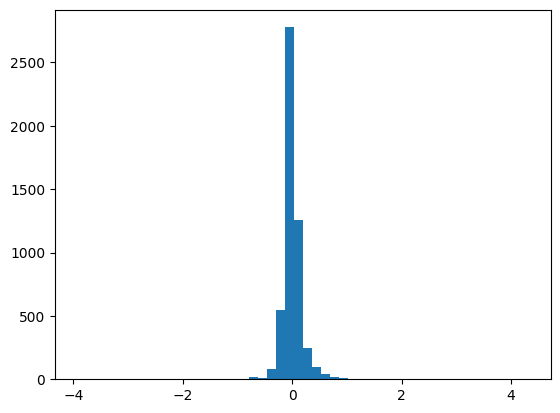

fc
Range:  8.247196197509766
3-sigma range: 1.2917067110538483


In [17]:
import matplotlib.pyplot as plt

conv1_weights = model.fc.weight.cpu().detach().numpy().flatten()

plt.hist(conv1_weights, bins=50)
plt.show()

print("fc")
print("Range: ",(conv1_weights.max() - conv1_weights.min()).item())
print("3-sigma range:",6*conv1_weights.std())


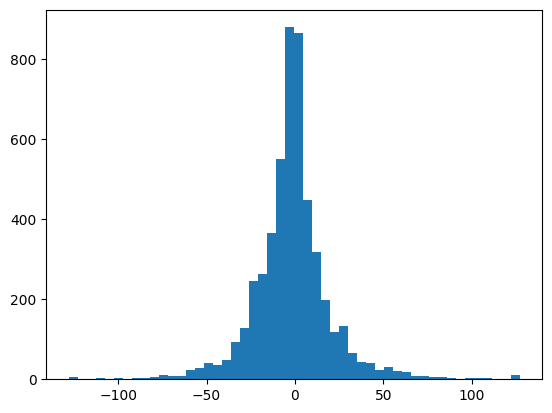

fc
127 -128
3-sigma range: 133.37839583159402


In [18]:
import matplotlib.pyplot as plt

conv1_weights = quantized_model.model_fp32.fc.weight().cpu().detach().int_repr().numpy().flatten()

plt.hist(conv1_weights, bins=50)
plt.show()

print("fc")
# print("Range: ",(conv1_weights.max() - conv1_weights.min()))
print(conv1_weights.max(),conv1_weights.min())
print("3-sigma range:",6*conv1_weights.std())


#QAT

In [19]:
# Load a pretrained model.
model = load_model(model=model,
                    model_filepath=model_filepath,
                    device=cuda_device)
# Move the model to CPU since static quantization does not support CUDA currently.
model.to(cpu_device)
# Make a copy of the model for layer fusion
# fused_model = create_model(num_classes=num_classes)
fused_model = copy.deepcopy(model)

model.train()
# The model has to be switched to training mode before any layer fusion.
# Otherwise the quantization aware training will not work correctly.
fused_model.eval()
# Fuse the model in place rather manually.
fused_model = torch.quantization.fuse_modules(fused_model,
                                              [["conv1", "relu"]],
                                              inplace=True)
for module_name, module in fused_model.named_children():
    if "layer" in module_name:
        for basic_block_name, basic_block in module.named_children():
            torch.quantization.fuse_modules(
                basic_block, [["conv1", "relu1"]],
                inplace=True)
            # for sub_block_name, sub_block in basic_block.named_children():
            #     if sub_block_name == "downsample":
            #         torch.quantization.fuse_modules(sub_block,
            #                                         [["0", "1"]],
            #                                         inplace=True)

# Print FP32 model.
# print(model)
# Print fused model.
# print(fused_model)

# Model and fused model should be equivalent.
model.eval()
fused_model.eval()
assert model_equivalence(
    model_1=model,
    model_2=fused_model,
    device=cpu_device,
    rtol=1e-03,
    atol=1e-06,
    num_tests=100,
    input_size=(
        1, 3, 32,
        32)), "Fused model is not equivalent to the original model!"

fused_model.train()
# Prepare the model for quantization aware training. This inserts observers in
# the model that will observe activation tensors during calibration.
quantized_model = QuantizedResNet18(model_fp32=fused_model)
# Using un-fused model will fail.
# Because there is no quantized layer implementation for a single batch normalization layer.
# quantized_model = QuantizedResNet18(model_fp32=model)
# Select quantization schemes from
# https://pytorch.org/docs/stable/quantization-support.html
quantization_config = torch.quantization.get_default_qconfig("fbgemm")
# Custom quantization configurations
# quantization_config = torch.quantization.default_qconfig
# quantization_config = torch.quantization.QConfig(activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.quint8), weight=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_tensor_symmetric))

quantized_model.qconfig = quantization_config

# Print quantization configurations
print(quantized_model.qconfig)

# https://pytorch.org/docs/stable/_modules/torch/quantization/quantize.html#prepare_qat
torch.quantization.prepare_qat(quantized_model, inplace=True)

# # Use training data for calibration.
print("Training QAT Model...")
quantized_model.train()
train_model(model=quantized_model,
            train_loader=train_loader,
            test_loader=test_loader,
            device=cuda_device,
            learning_rate=1e-3,
            num_epochs=5)
quantized_model.to(cpu_device)

# Using high-level static quantization wrapper
# The above steps, including torch.quantization.prepare, calibrate_model, and torch.quantization.convert, are also equivalent to
# quantized_model = torch.quantization.quantize_qat(model=quantized_model, run_fn=train_model, run_args=[train_loader, test_loader, cuda_device], mapping=None, inplace=False)

quantized_model = torch.quantization.convert(quantized_model, inplace=True)

quantized_model.eval()

# Print quantized model.
# print(quantized_model)

# Save quantized model.
save_torchscript_model(model=quantized_model,
                        model_dir=model_dir,
                        model_filename=quantized_model_filename)

# Load quantized model.
quantized_jit_model = load_torchscript_model(
    model_filepath=quantized_model_filepath, device=cpu_device)

_, fp32_eval_accuracy = evaluate_model(model=model,
                                        test_loader=test_loader,
                                        device=cpu_device,
                                        criterion=None)
_, int8_eval_accuracy = evaluate_model(model=quantized_jit_model,
                                        test_loader=test_loader,
                                        device=cpu_device,
                                        criterion=None)

# Skip this assertion since the values might deviate a lot.
# assert model_equivalence(model_1=model, model_2=quantized_jit_model, device=cpu_device, rtol=1e-01, atol=1e-02, num_tests=100, input_size=(1,3,32,32)), "Quantized model deviates from the original model too much!"

print("FP32 evaluation accuracy: {:.3f}".format(fp32_eval_accuracy))
print("INT8 evaluation accuracy: {:.3f}".format(int8_eval_accuracy))

fp32_cpu_inference_latency = measure_inference_latency(model=model,
                                                        device=cpu_device,
                                                        input_size=(1, 3,
                                                                    32, 32),
                                                        num_samples=100)
int8_cpu_inference_latency = measure_inference_latency(
    model=quantized_model,
    device=cpu_device,
    input_size=(1, 3, 32, 32),
    num_samples=100)
int8_jit_cpu_inference_latency = measure_inference_latency(
    model=quantized_jit_model,
    device=cpu_device,
    input_size=(1, 3, 32, 32),
    num_samples=100)
fp32_gpu_inference_latency = measure_inference_latency(model=model,
                                                        device=cuda_device,
                                                        input_size=(1, 3,
                                                                    32, 32),
                                                        num_samples=100)

print("FP32 CPU Inference Latency: {:.2f} ms / sample".format(
    fp32_cpu_inference_latency * 1000))
print("FP32 CUDA Inference Latency: {:.2f} ms / sample".format(
    fp32_gpu_inference_latency * 1000))
print("INT8 CPU Inference Latency: {:.2f} ms / sample".format(
    int8_cpu_inference_latency * 1000))
print("INT8 JIT CPU Inference Latency: {:.2f} ms / sample".format(
    int8_jit_cpu_inference_latency * 1000))

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})
Training QAT Model...
Epoch: -1 Eval Loss: 1.414 Eval Acc: 0.572
Epoch: 000 Train Loss: 0.973 Train Acc: 0.693 Eval Loss: 1.208 Eval Acc: 0.639 Train Time: 34.045s Eval Time: 4.682s Train Mem: 155194368B Eval Mem: 155194368B
Epoch: 001 Train Loss: 0.852 Train Acc: 0.731 Eval Loss: 1.171 Eval Acc: 0.653 Train Time: 33.308s Eval Time: 5.072s Train Mem: 155194368B Eval Mem: 155194368B
Epoch: 002 Train Loss: 0.798 Train Acc: 0.746 Eval Loss: 1.151 Eval Acc: 0.661 Train Time: 31.775s Eval Time: 6.009s Train Mem: 155194368B Eval Mem: 155194368B
Epoch: 003 Train Loss: 0.763 Train Acc: 0.755 Eval Loss: 1.140 Eval Acc: 0.665 Train Time: 31.907s Eval Time: 5.228s Train Mem: 155194368B Eval Mem: 155194368B
Epoch: 004 Train Loss: 0.

In [20]:
import os
import torch

def model_size(models, model_save_name="temp_model.pt"):
    torch.save(models.state_dict(), model_save_name)
    model_size = os.path.getsize(model_save_name)
    os.remove(model_save_name) # remove the temporary file
    return model_size

# model = ...  # This is your model
size = model_size(model)
print(f"Model size: {size / 1024 / 1024} MB")

size = model_size(quantized_model)
print(f"Model size: {size / 1024 / 1024} MB")

size = model_size(quantized_jit_model)
print(f"Model size: {size / 1024 / 1024} MB")

Model size: 42.627055168151855 MB
Model size: 10.7666654586792 MB
Model size: 0.004015922546386719 MB


In [21]:
from torch.profiler import profile, record_function, ProfilerActivity
inputs = torch.randn(5, 3, 32, 32).to(cpu_device)
model.to(cpu_device)
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True,record_shapes=True) as prof:
  with record_function("Quantaware"):
      quantized_model(inputs)


prof.export_chrome_trace("Quantaware.json")
# Print aggregated stats
print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=5))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       Quantaware        36.24%       4.814ms        99.85%      13.262ms      13.262ms           0 b    -360.24 Kb             1  
                quantized::conv2d        27.04%       3.592ms        28.60%       3.799ms     345.364us      92.50 Kb    -370.00 Kb            11  
           quantized::conv2d_relu        25.03%       3.325ms        26.76%       3.554ms     394.889us     155.00 Kb    -635.00 Kb             9  
                   quantized::add         3.09%     411.000us         3.74%     497.000us      62.125us      75.

In [22]:
from torch.profiler import profile, record_function, ProfilerActivity
inputs = torch.randn(5, 3, 32, 32).to(cpu_device)
model.to(cpu_device)
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True,record_shapes=True) as prof:
  with record_function("Quant JIT aware"):
      quantized_jit_model(inputs)


prof.export_chrome_trace("Quantjitaware.json")
# Print aggregated stats
print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=5))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                quantized::conv2d        41.77%       2.819ms        42.54%       2.871ms     261.000us      17.50 Kb    -445.00 Kb            11  
           quantized::conv2d_relu        39.09%       2.638ms        43.38%       2.928ms     325.333us     140.00 Kb    -630.00 Kb             9  
                          forward         3.62%     244.000us        96.95%       6.543ms       6.543ms         200 b     -70.00 Kb             1  
                      aten::clone         2.84%     192.000us         3.05%     206.000us     206.000us      15.

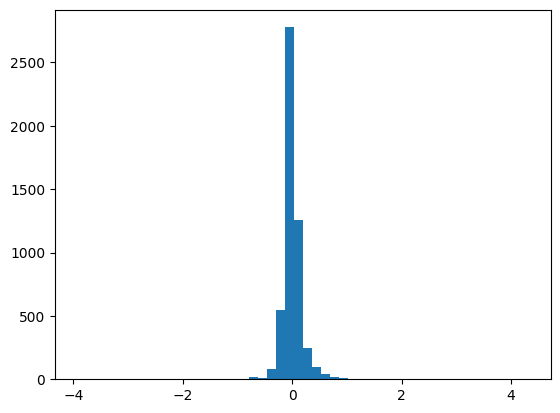

fc
Range:  8.247196197509766
3-sigma range: 1.2917067110538483


In [23]:
import matplotlib.pyplot as plt

conv1_weights = model.fc.weight.cpu().detach().numpy().flatten()

plt.hist(conv1_weights, bins=50)
plt.show()

print("fc")
print("Range: ",(conv1_weights.max() - conv1_weights.min()).item())
print("3-sigma range:",6*conv1_weights.std())


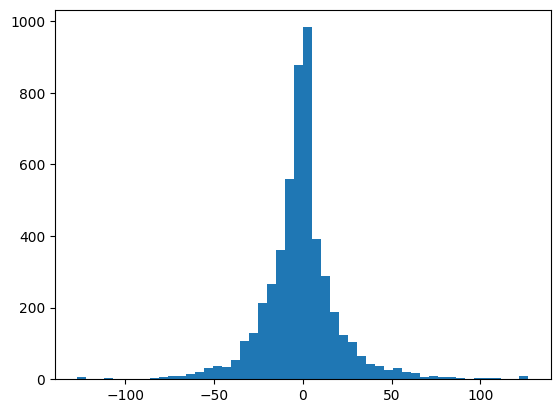

fc
127 -127
3-sigma range: 133.09711881366562


In [24]:
import matplotlib.pyplot as plt

conv1_weights = quantized_model.model_fp32.fc.weight().cpu().detach().int_repr().numpy().flatten()

plt.hist(conv1_weights, bins=50)
plt.show()

print("fc")
# print("Range: ",(conv1_weights.max() - conv1_weights.min()))
print(conv1_weights.max(),conv1_weights.min())
print("3-sigma range:",6*conv1_weights.std())
